### We will start by importing all the necessary libraries and preparing the data for the later steps as well as getting all directories to extrtact the needed data

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import shap
from pathlib import Path

import sys
import os

current_path = Path(os.getcwd()) # Start from where Jupyter was launched or current notebook directory
project_root = None
for p in [current_path] + list(current_path.parents):
    if (p / '.git').is_dir():
        project_root = p
        break

if project_root is None:
    raise RuntimeError("Could not find the Git repository root. Make sure you are running the notebook from within the repository.")

print(f"**Identified Project Root:** {project_root}")

# Construct the path to your data directory
data_dir = project_root / 'data'
print(f"Data Directory Path: {data_dir}")

# Construct the path to your src directory
src_dir = project_root / 'src'
print(f"Source Directory Path: {src_dir}")

file_path_80 = data_dir /'sampling_results_post_MiNs_max_absent_for_yield_80.0.parquet'
file_path_70 = data_dir /'sampling_results_post_MiNs_max_absent_for_yield_70.0.parquet'
file_path_60 = data_dir /'sampling_results_post_MiNs_max_absent_for_yield_60.0.parquet'
file_path_50 = data_dir /'sampling_results_post_MiNs_max_absent_for_yield_50.0.parquet'
file_path_100 = data_dir /'sampling_results_post_MiNs_max_absent_for_yield_100.0.parquet'
file_path_90 = data_dir /'sampling_results_post_MiNs_max_absent_for_yield_90.0.parquet'


**Identified Project Root:** /Users/Christian/Desktop/AI for chem final/CH-457-Team-4-submission
Data Directory Path: /Users/Christian/Desktop/AI for chem final/CH-457-Team-4-submission/data
Source Directory Path: /Users/Christian/Desktop/AI for chem final/CH-457-Team-4-submission/src


### Preparing the data for the next steps

In [21]:
from utils import merge_forward_reverse_fluxes, convert_fluxes_to_sign
from utils2 import load_custom_json_model, load_results_parquet

# Set random seed for reproducibility
np.random.seed(42)

# Check the working directory
print(os.getcwd())

import pandas as pd


samples80 = pd.read_parquet(file_path_80)


# Format the dataframe in a convenient way
df_80 = merge_forward_reverse_fluxes(samples80) # df stands for data frame
df_80 = df_80.loc[:, ~df_80.columns.str.startswith(('DG_', 'DGo_', 'LC_'))]
df_80.drop(columns=df_80.columns[0], inplace=True)
df_80['Percentage'] = 80


samples70 = pd.read_parquet(file_path_70)



# Format the dataframe in a convenient way
df_70 = merge_forward_reverse_fluxes(samples70)
df_70 = df_70.loc[:, ~df_70.columns.str.startswith(('DG_', 'DGo_', 'LC_'))]
df_70.drop(columns=df_70.columns[0], inplace=True)
df_70['Percentage'] = 70


samples60 = pd.read_parquet(file_path_60)


df_60 = merge_forward_reverse_fluxes(samples60)
df_60 = df_60.loc[:, ~df_60.columns.str.startswith(('DG_', 'DGo_', 'LC_'))]
df_60.drop(columns=df_60.columns[0], inplace=True)
df_60['Percentage'] = 60


samples50 = pd.read_parquet(file_path_50)


df_50 = merge_forward_reverse_fluxes(samples50)
df_50 = df_50.loc[:, ~df_50.columns.str.startswith(('DG_', 'DGo_', 'LC_'))]
df_50.drop(columns=df_50.columns[0], inplace=True)
df_50['Percentage'] = 50


samples100 = pd.read_parquet(file_path_100)


df_100 = merge_forward_reverse_fluxes(samples100)
df_100 = df_100.loc[:, ~df_100.columns.str.startswith(('DG_', 'DGo_', 'LC_'))]
df_100.drop(columns=df_100.columns[0], inplace=True)
df_100['Percentage'] = 100

samples90 = pd.read_parquet(file_path_90)


df_90 = merge_forward_reverse_fluxes(samples90)
df_90 = df_90.loc[:, ~df_90.columns.str.startswith(('DG_', 'DGo_', 'LC_'))]
df_90.drop(columns=df_90.columns[0], inplace=True)
df_90['Percentage'] = 90

# Get the union of all columns (excluding 'Percentage')
all_columns = set(df_70.columns) | set(df_80.columns) | set(df_100.columns) | set(df_60.columns) | set(df_50.columns) | set(df_90.columns)
all_columns.discard('Percentage')  # remove the label column

all_columns = sorted(all_columns)

# Function to reindex and fill missing columns
def align_columns(df):
    df_aligned = df.reindex(columns=all_columns, fill_value=0)  # use fill_value=np.nan if you prefer
    df_aligned['Percentage'] = df['Percentage']  # add label back
    return df_aligned

# Align all DataFrames
df_70_aligned = align_columns(df_70)
df_80_aligned = align_columns(df_80)
df_100_aligned = align_columns(df_100)
df_60_aligned = align_columns(df_60)
df_50_aligned = align_columns(df_50)
df_90_aligned = align_columns(df_90)

# Concatenate
df_all = pd.concat([df_70_aligned, df_80_aligned, df_100_aligned, df_50_aligned], axis=0, ignore_index=True)
df_all = pd.get_dummies(df_all)

#Removing reactiosn which defined the constrained sampling
X = df_all.drop(['Percentage','EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)
y = df_all['Percentage']



/Users/Christian/Desktop/AI for chem final/CH-457-Team-4-submission/src


### We can now go ahead and train the Random Forest Classifier

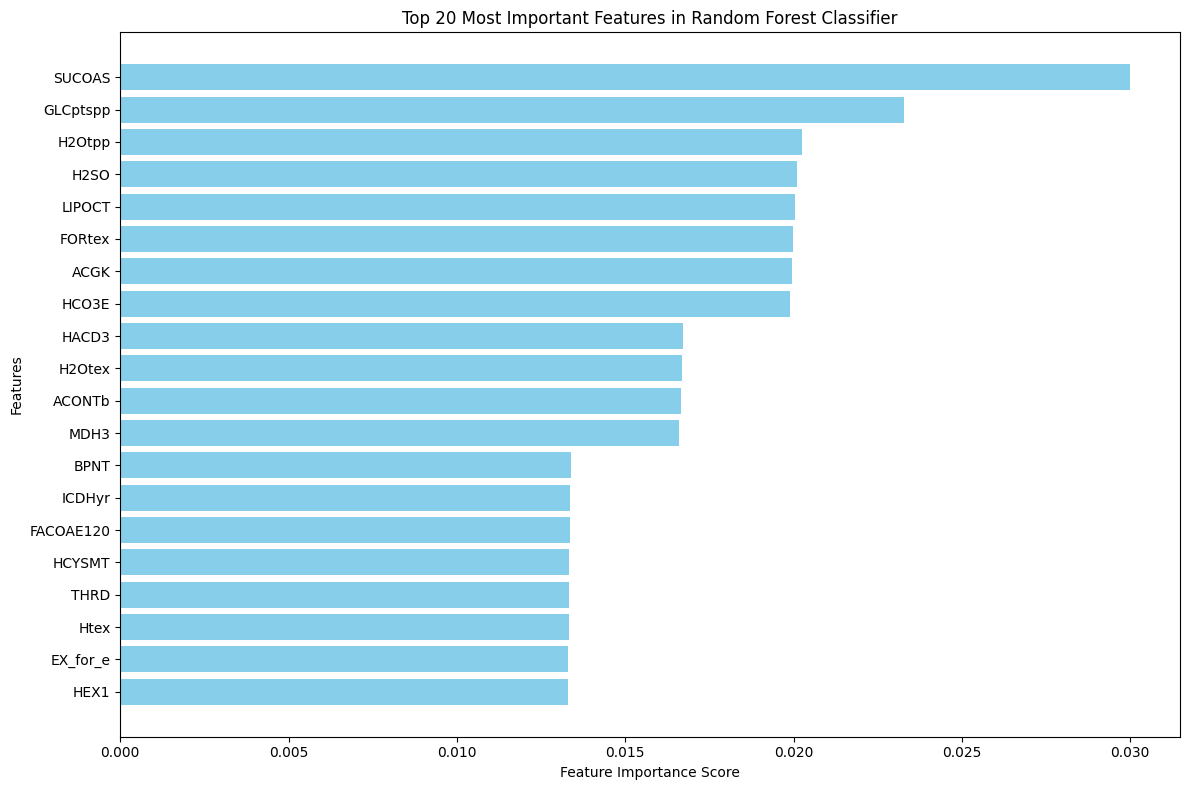

/var/folders/hn/x_605c8j4sqcfy89566z5jsh0000gp/T/ipykernel_24337/3887590963.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=['50%', '70%', '80%', '100%'], plot_type="bar")


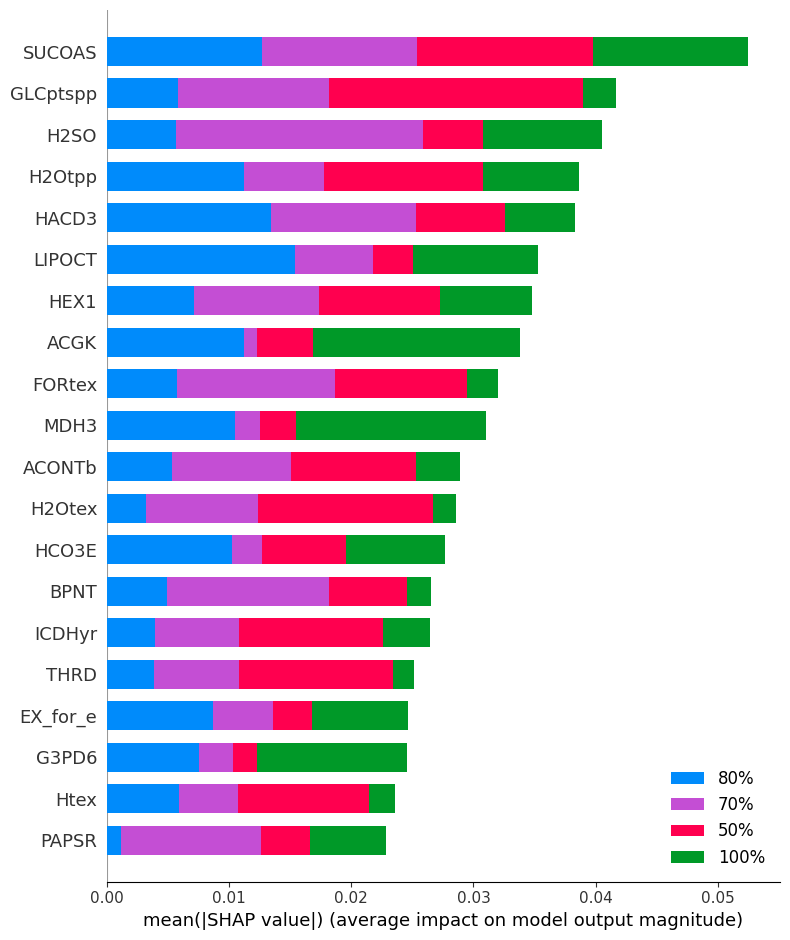

Text(0.5, 1.0, 'Confusion matrix for validation data')

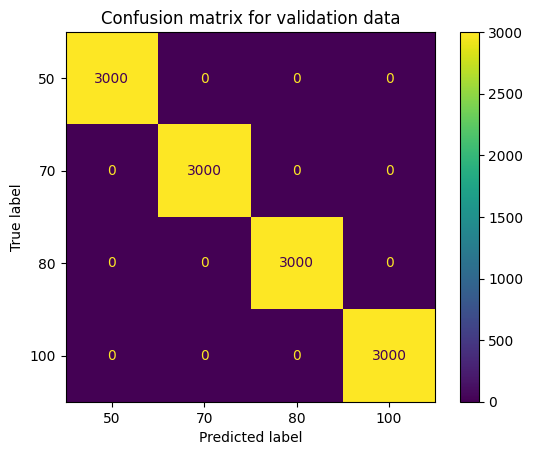

In [22]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# For simplicity, training on the whole dataset just to get feature importances for cluster definition
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

top_20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)
top_20_features_array=top_20_features['feature'].values

plt.figure(figsize=(12, 8)) # Adjust figure size for better readability
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 20 Most Important Features in Random Forest Classifier")
plt.gca().invert_yaxis()
plt.tight_layout() 
plt.show()

explainer = shap.TreeExplainer(rfc)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=['50%', '70%', '80%', '100%'], plot_type="bar")

#Evaluating the model on validation data to obtain a confusion matrix
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
disp.ax_.set_title("Confusion matrix for validation data")

### Box plots for the visualization of the assignment probability distributions

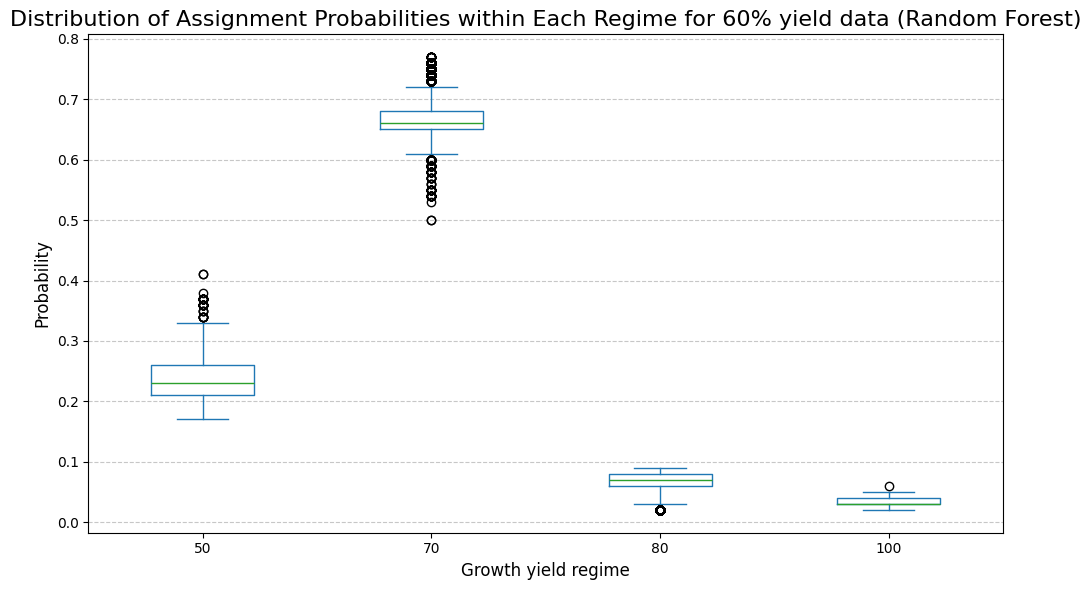

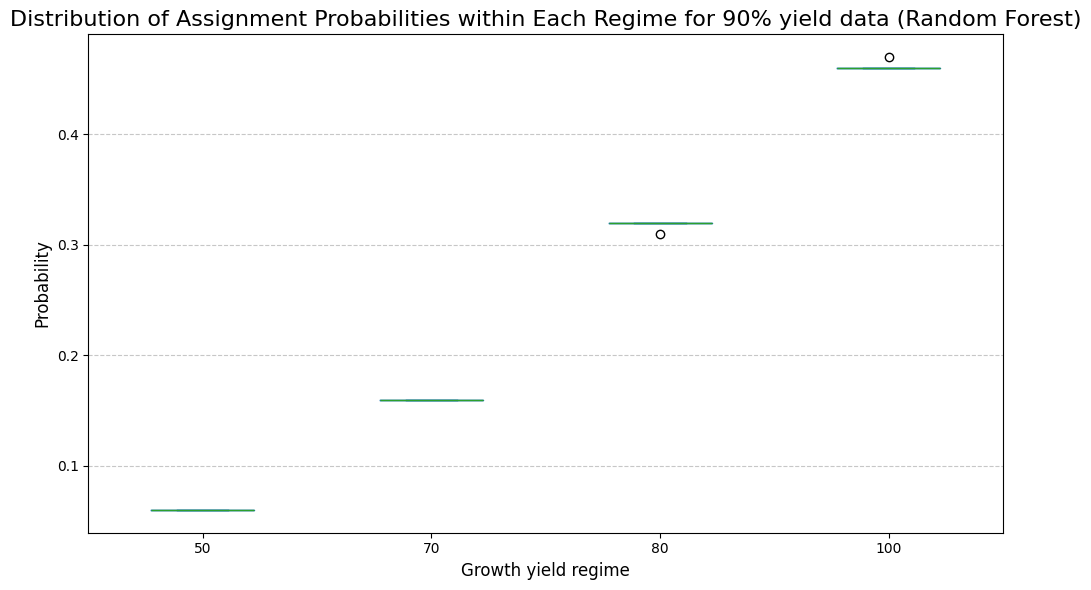

In [23]:
# Preparing unseen data to obtain assignment probabilities
X_60 = df_60_aligned.drop(['Percentage','BIOMASS_Ec_iJO1366_WT_53p95M', 'EX_glc__D_e'], axis=1)

X_60_scaled = scaler.transform(X_60)
probabilities_60 = rfc.predict_proba(X_60_scaled)
prob_df_60 = pd.DataFrame(probabilities_60, columns=rfc.classes_) #Placing the probabilities in a DataFrame

#Doing the same for the 90% growth yield data
X_90 = df_90_aligned.drop(['Percentage', 'EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)

X_90_scaled = scaler.transform(X_90)
probabilities_90 = rfc.predict_proba(X_90_scaled)
prob_df_90 = pd.DataFrame(probabilities_90, columns=rfc.classes_)

#For the 60% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_60.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('Distribution of Assignment Probabilities within Each Regime for 60% yield data (Random Forest)'
, fontsize=16
)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()

#For the 90% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_90.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('Distribution of Assignment Probabilities within Each Regime for 90% yield data (Random Forest)', 
fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()



### PCA to visualize the data structure

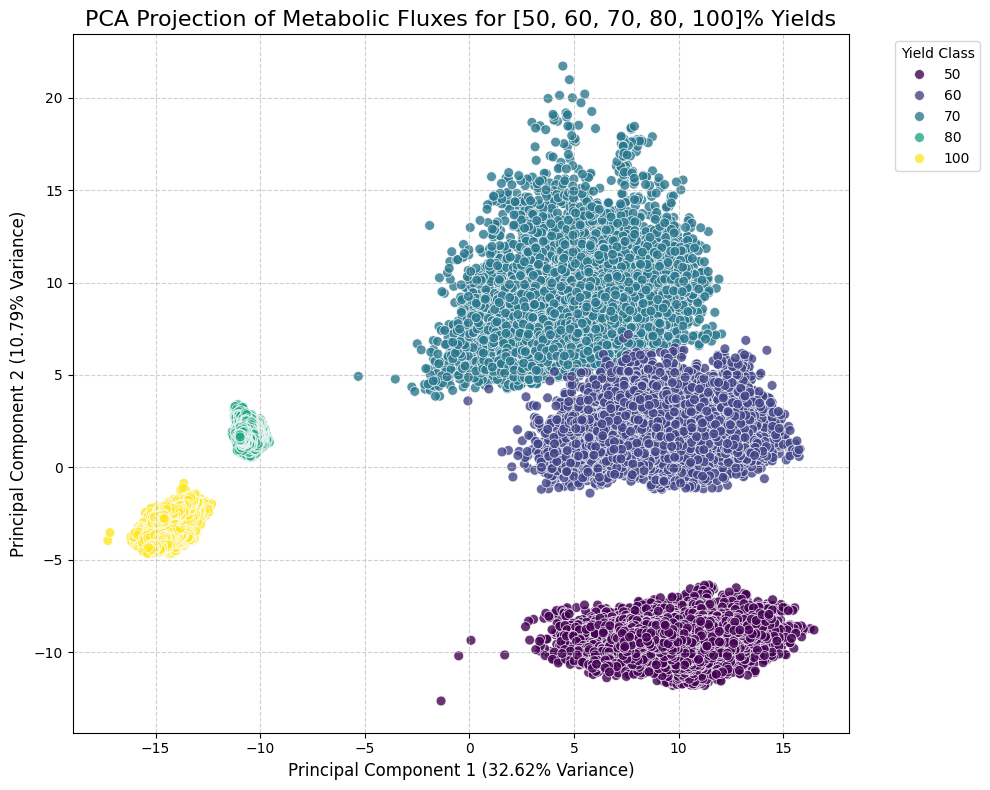

In [24]:
scaler_pca=StandardScaler()

# Filter for the relevant yield classes (50%, 60%, 70%, 80%, 100%)
regimes_of_interest = [50, 60, 70, 80, 100]

# --- Apply PCA Dimensionality Reduction ---
# If None, PCA will return all components, and you can analyze explained variance.
pca = PCA(n_components=2, random_state=42) # We want 2 components for a 2D plot

data_for_pca=pd.concat([df_70_aligned, df_80_aligned, df_100_aligned, df_50_aligned, df_60_aligned], axis=0, ignore_index=True)

X_for_pca=data_for_pca.drop(['Percentage', 'EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)
X_for_pca_scaled=scaler_pca.fit_transform(X_for_pca)
# Fit PCA and transform the scaled data
embedding_pca = pca.fit_transform(X_for_pca_scaled)



df_embedding_pca = pd.DataFrame(embedding_pca, columns=['PC1', 'PC2'])
df_embedding_pca['yield_class'] = data_for_pca['Percentage'].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='yield_class', # Color points based on the 'yield_class' column
    palette='viridis', # A nice color palette
    s=50, # Size of the points
    alpha=0.8, # Transparency of the points
    data=df_embedding_pca
)
plt.title(f'PCA Projection of Metabolic Fluxes for {regimes_of_interest}% Yields', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=12)
plt.legend(title='Yield Class', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust plot to prevent labels from overlapping
plt.show()

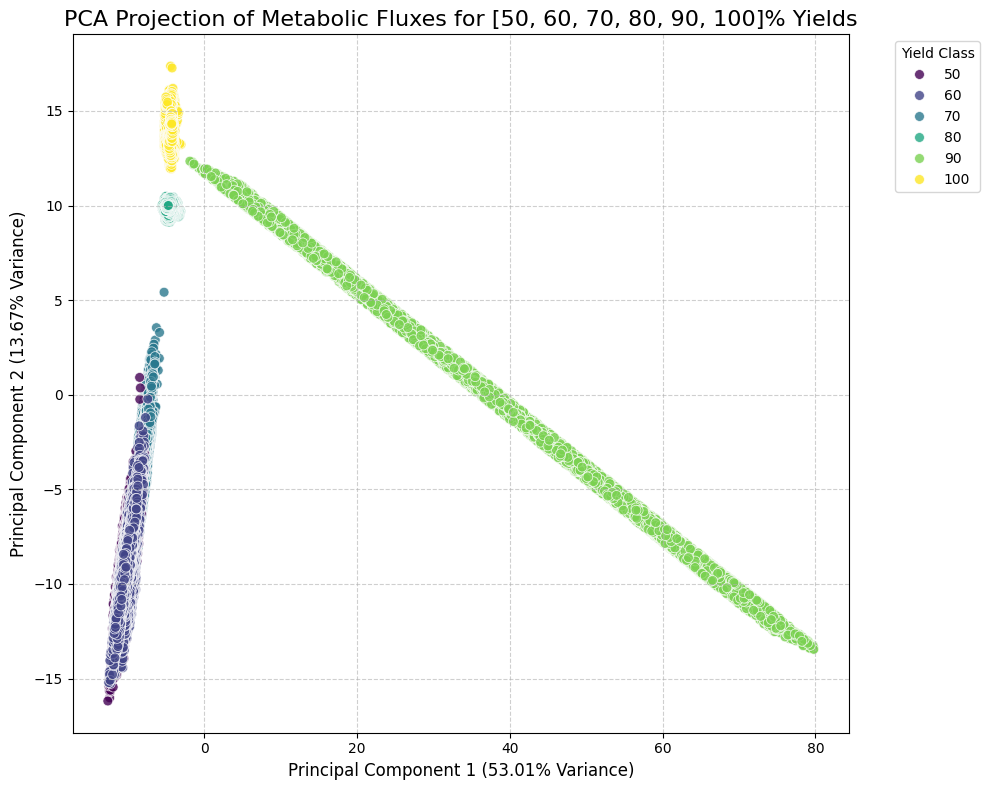

In [25]:
scaler_pca=StandardScaler()

# Filter for the relevant yield classes (50%, 60%, 70%, 80%, 100%)
regimes_of_interest = [50, 60, 70, 80,90, 100]

# --- Apply PCA Dimensionality Reduction ---
# If None, PCA will return all components, and you can analyze explained variance.
pca = PCA(n_components=2, random_state=42) # We want 2 components for a 2D plot

data_for_pca=pd.concat([df_70_aligned, df_80_aligned, df_100_aligned, df_50_aligned, df_60_aligned, df_90_aligned], axis=0, ignore_index=True)

X_for_pca=data_for_pca.drop(['Percentage', 'EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)
X_for_pca_scaled=scaler_pca.fit_transform(X_for_pca)
# Fit PCA and transform the scaled data
embedding_pca = pca.fit_transform(X_for_pca_scaled)



df_embedding_pca = pd.DataFrame(embedding_pca, columns=['PC1', 'PC2'])
df_embedding_pca['yield_class'] = data_for_pca['Percentage'].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='yield_class', # Color points based on the 'yield_class' column
    palette='viridis', # A nice color palette
    s=50, # Size of the points
    alpha=0.8, # Transparency of the points
    data=df_embedding_pca
)
plt.title(f'PCA Projection of Metabolic Fluxes for {regimes_of_interest}% Yields', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=12)
plt.legend(title='Yield Class', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust plot to prevent labels from overlapping
plt.show()

### Doing the same classification task, now with a Logistic Regressor model

/Users/Christian/Desktop/AI for chem final/myVE/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/var/folders/hn/x_605c8j4sqcfy89566z5jsh0000gp/T/ipykernel_24337/1096008850.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=['50%', '70%', '80%', '100%'], plot_type="bar")


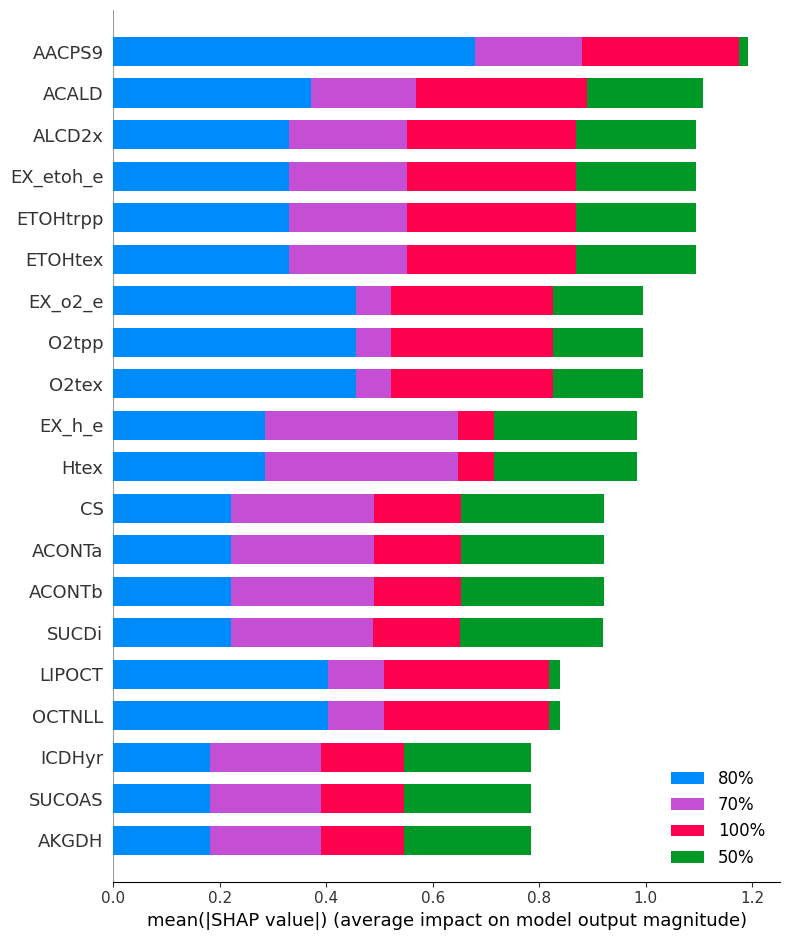

Text(0.5, 1.0, 'Confusion matrix for validation data')

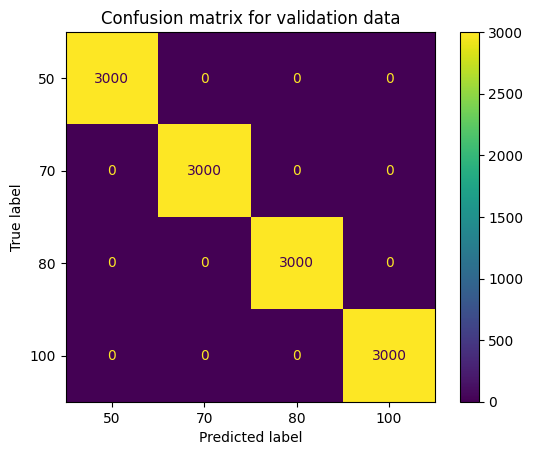

In [26]:
lr=LogisticRegression(random_state=42, solver='liblinear', multi_class='auto')

lr=LogisticRegression(random_state=42, solver='liblinear', multi_class='auto')
lr.fit(X_train, y_train)

explainer = shap.LinearExplainer(
    lr,
    X_train, # Use the training data as the background dataset
    feature_names=X.columns.tolist(), # Pass feature names
)


shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=['50%', '70%', '80%', '100%'], plot_type="bar")

#Evaluating the model on validation data to obtain a confusion matrix
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
disp.ax_.set_title("Confusion matrix for validation data")

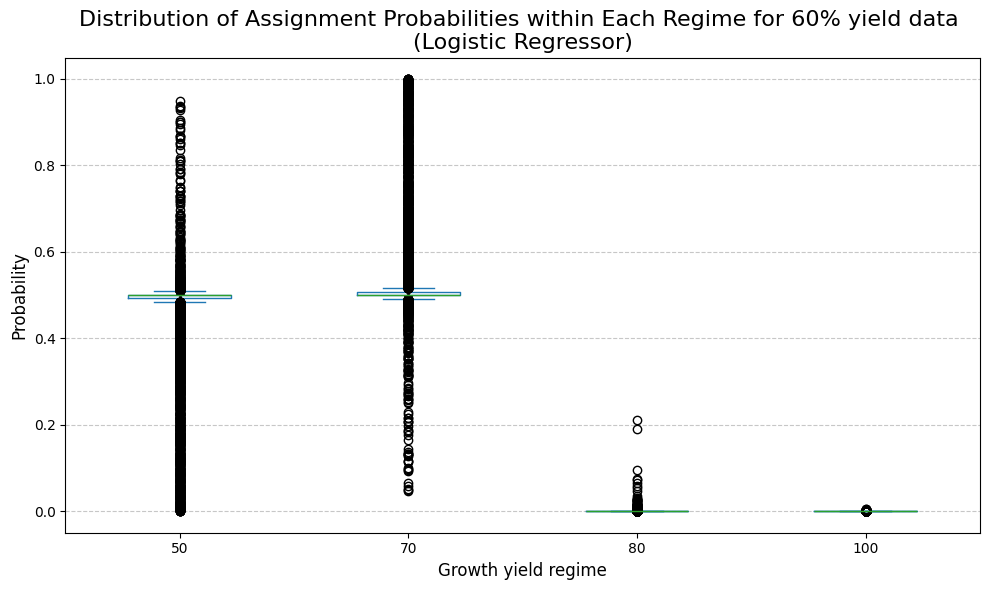

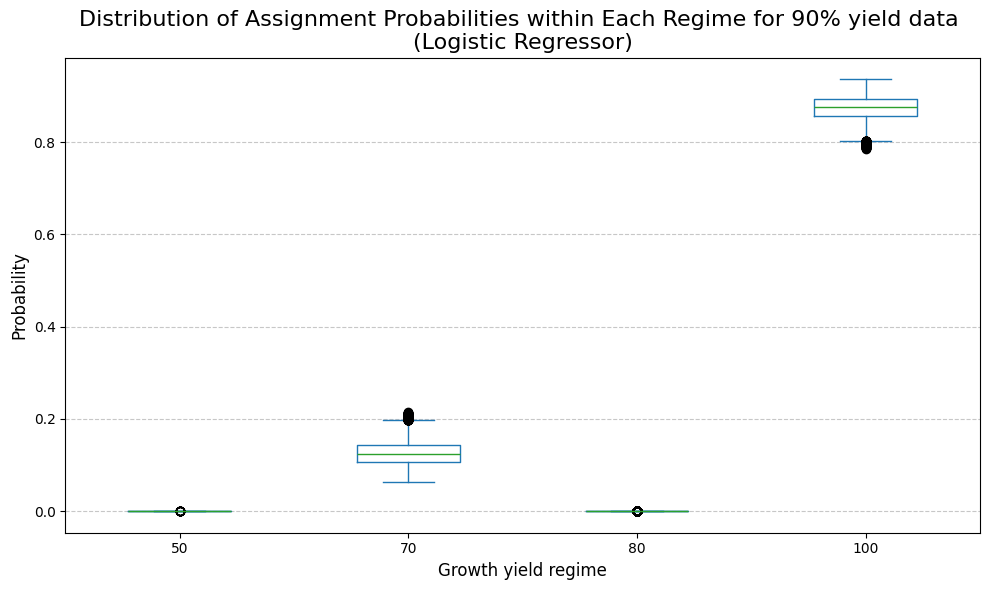

In [27]:
# Preparing unseen data to obtain assignment probabilities
X_60 = df_60_aligned.drop(['Percentage','BIOMASS_Ec_iJO1366_WT_53p95M', 'EX_glc__D_e'], axis=1)

X_60_scaled = scaler.transform(X_60)
probabilities_60 = lr.predict_proba(X_60_scaled)
prob_df_60 = pd.DataFrame(probabilities_60, columns=rfc.classes_) #Placing the probabilities in a DataFrame

#Doing the same for the 90% growth yield data
X_90 = df_90_aligned.drop(['Percentage', 'EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)

X_90_scaled = scaler.transform(X_90)
probabilities_90 = lr.predict_proba(X_90_scaled)
prob_df_90 = pd.DataFrame(probabilities_90, columns=rfc.classes_)

#For the 60% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_60.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('''Distribution of Assignment Probabilities within Each Regime for 60% yield data 
(Logistic Regressor)''', fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()

#For the 90% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_90.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('''Distribution of Assignment Probabilities within Each Regime for 90% yield data 
(Logistic Regressor)''', fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()

### Same thing with a Gaussian Naive Bayes model

Text(0.5, 1.0, 'Confusion matrix for validation data')

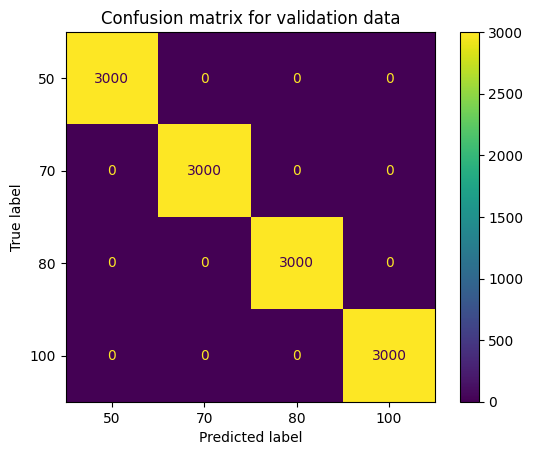

In [28]:
nb=GaussianNB()

nb=GaussianNB()
nb.fit(X_train, y_train)

#Evaluating the model on validation data to obtain a confusion matrix
y_pred = nb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()
disp.ax_.set_title("Confusion matrix for validation data")

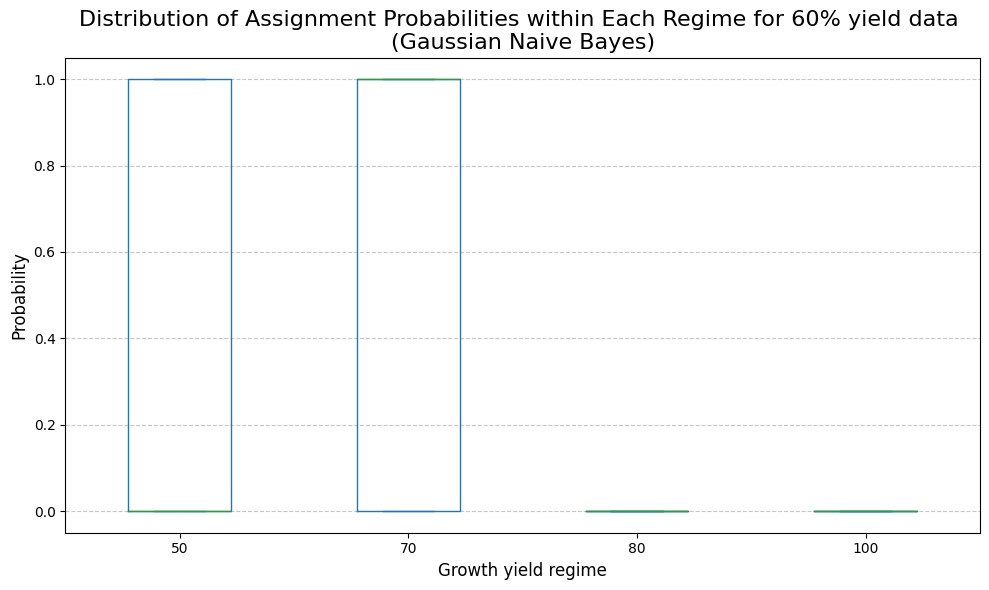

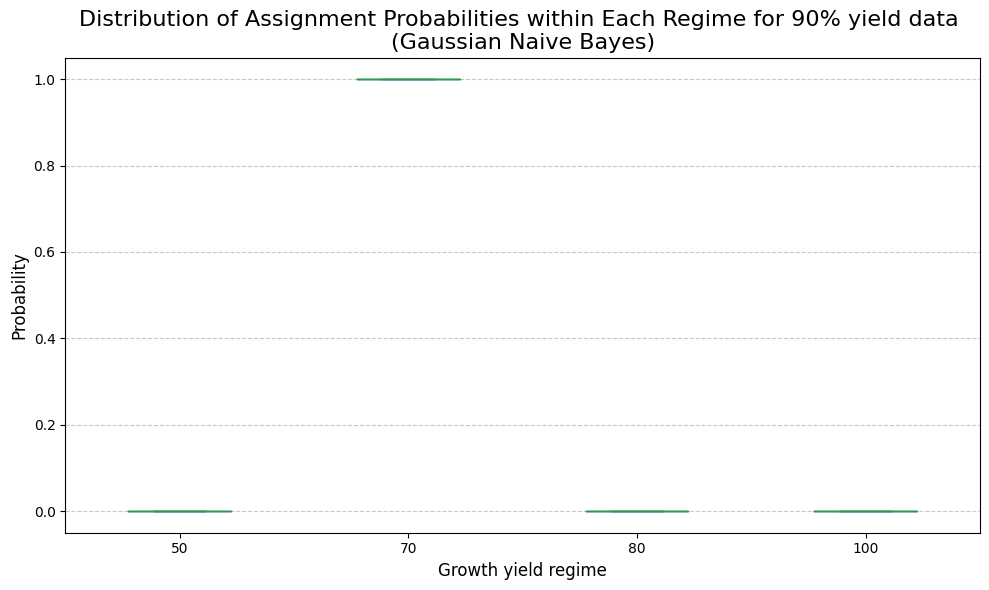

In [29]:
# Preparing unseen data to obtain assignment probabilities
X_60 = df_60_aligned.drop(['Percentage','BIOMASS_Ec_iJO1366_WT_53p95M', 'EX_glc__D_e'], axis=1)

X_60_scaled = scaler.transform(X_60)
probabilities_60 = nb.predict_proba(X_60_scaled)
prob_df_60 = pd.DataFrame(probabilities_60, columns=rfc.classes_) #Placing the probabilities in a DataFrame

#Doing the same for the 90% growth yield data
X_90 = df_90_aligned.drop(['Percentage', 'EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)

X_90_scaled = scaler.transform(X_90)
probabilities_90 = nb.predict_proba(X_90_scaled)
prob_df_90 = pd.DataFrame(probabilities_90, columns=rfc.classes_)

#For the 60% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_60.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('''Distribution of Assignment Probabilities within Each Regime for 60% yield data 
(Gaussian Naive Bayes)''', fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()

#For the 90% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_90.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('''Distribution of Assignment Probabilities within Each Regime for 90% yield data 
(Gaussian Naive Bayes)''', fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()

### Using a Decision Tree Classifier

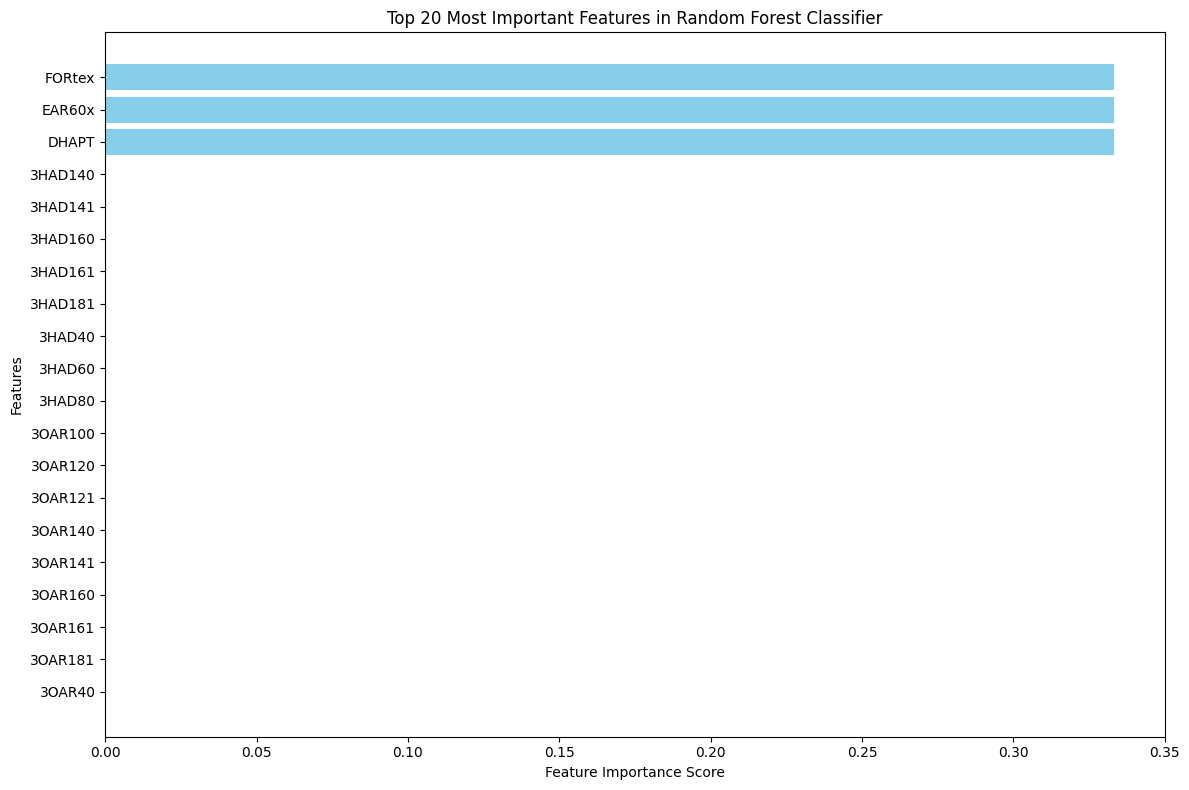

/var/folders/hn/x_605c8j4sqcfy89566z5jsh0000gp/T/ipykernel_24337/1405519637.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=['50%', '70%', '80%', '100%'], plot_type="bar")


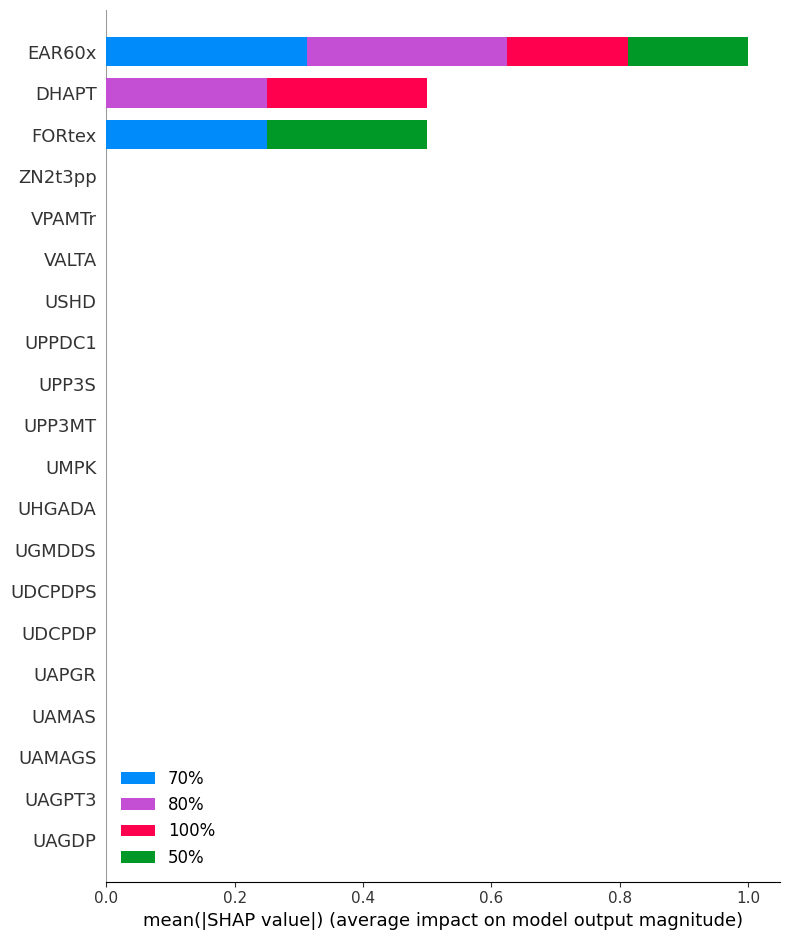

Text(0.5, 1.0, 'Confusion matrix for validation data')

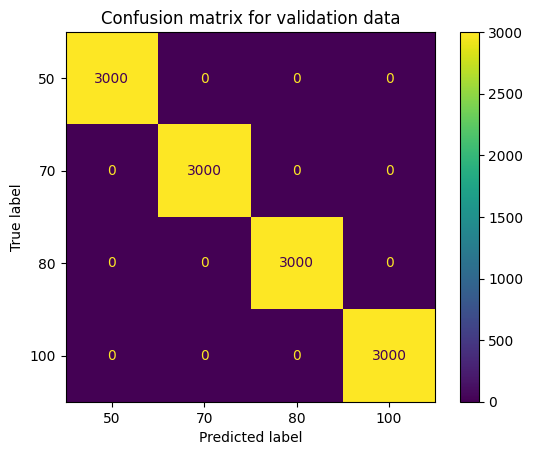

In [30]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X_train, y_train)

importances = dt.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

top_20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)
top_20_features_array=top_20_features['feature'].values

plt.figure(figsize=(12, 8)) # Adjust figure size for better readability
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 20 Most Important Features in Random Forest Classifier")
plt.gca().invert_yaxis()
plt.tight_layout() 
plt.show()

explainer = shap.TreeExplainer(dt)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns, class_names=['50%', '70%', '80%', '100%'], plot_type="bar")

#Evaluating the model on validation data to obtain a confusion matrix
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
disp.ax_.set_title("Confusion matrix for validation data")

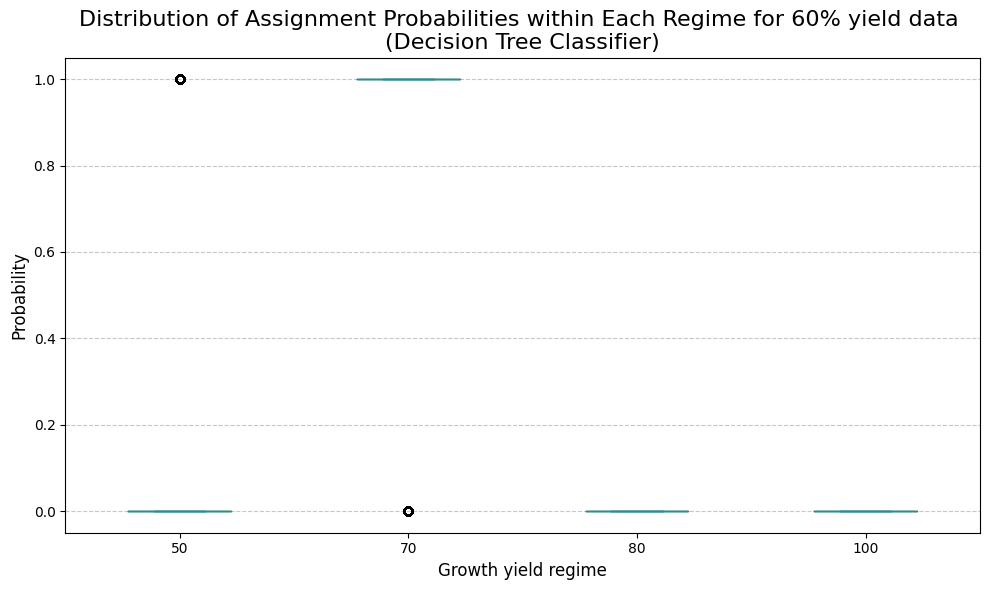

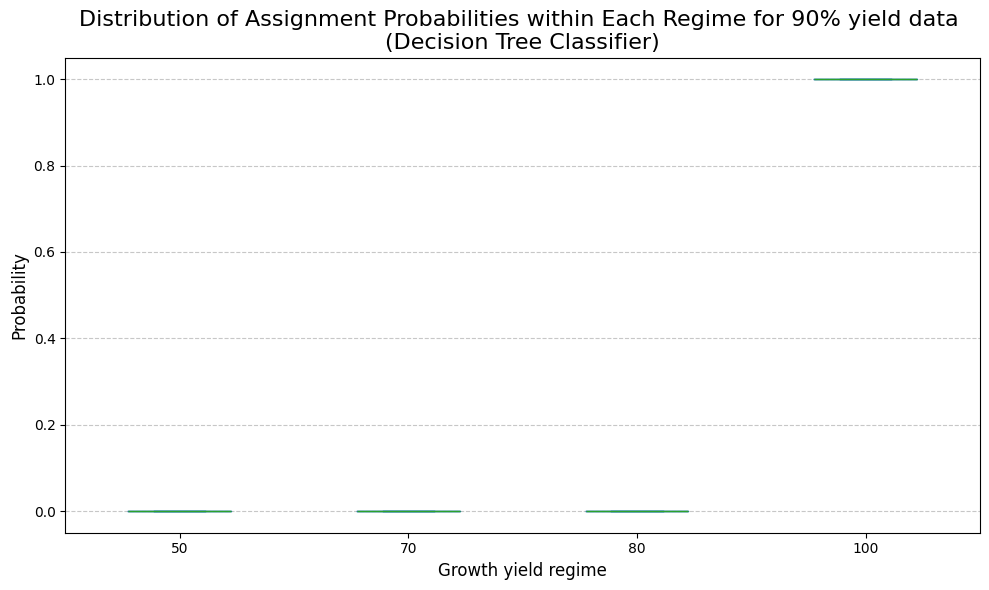

In [31]:
# Preparing unseen data to obtain assignment probabilities
X_60 = df_60_aligned.drop(['Percentage','BIOMASS_Ec_iJO1366_WT_53p95M', 'EX_glc__D_e'], axis=1)

X_60_scaled = scaler.transform(X_60)
probabilities_60 = dt.predict_proba(X_60_scaled)
prob_df_60 = pd.DataFrame(probabilities_60, columns=rfc.classes_) #Placing the probabilities in a DataFrame

#Doing the same for the 90% growth yield data
X_90 = df_90_aligned.drop(['Percentage', 'EX_glc__D_e', 'BIOMASS_Ec_iJO1366_WT_53p95M'], axis=1)

X_90_scaled = scaler.transform(X_90)
probabilities_90 = dt.predict_proba(X_90_scaled)
prob_df_90 = pd.DataFrame(probabilities_90, columns=rfc.classes_)

#For the 60% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_60.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('''Distribution of Assignment Probabilities within Each Regime for 60% yield data 
(Decision Tree Classifier)''', fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()

#For the 90% data
plt.figure(figsize=(10, 6))
ax_box = prob_df_90.plot(kind='box', ax=plt.gca()) # Plots one box per column

ax_box.set_title('''Distribution of Assignment Probabilities within Each Regime for 90% yield data 
(Decision Tree Classifier)''', fontsize=16)
ax_box.set_xlabel('Growth yield regime', fontsize=12)
ax_box.set_ylabel('Probability', fontsize=12)
ax_box.grid(True, linestyle='--', alpha=0.7, axis='y') # Grid lines on y-axis are often helpful for box plots
plt.tight_layout()
plt.show()